<a href="https://colab.research.google.com/github/YasminaNasser/Barcode_Reader/blob/main/Copy_of_Barcode_Reader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports



In [ ]:
import numpy as np
import cv2
import os
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import math
from scipy import fftpack


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Helper functions

In [ ]:
def thresholding(image, value=127):
  ret,thresh1 = cv2.threshold(image,value,255,cv2.THRESH_BINARY)
  return thresh1

def contour(image):
    inv = cv2.bitwise_not(image)
    x, y, w, h = cv2.boundingRect(inv)

    if y == 0 and x == 0 and h == image.shape[0] and w == image.shape[1]:
        return image
    crop = image[y:y+h-h//4, x:x+w]
    return crop


def calculate_vertical_bar_height(image):
    contoured = contour(image)
    if len(contoured.shape) == 2:
        height, _ = contoured.shape
    else:
        height, _, _ = contoured.shape
    return height

def apply_closing(image):
    closed_image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)))
    return closed_image

def apply_opening(image, bar_height):
    opened_image = cv2.morphologyEx(image, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (1, bar_height)))
    return opened_image

def crop_rows(image, num_rows=2):
    if image.shape[0] <= num_rows:
        raise ValueError("Image has fewer rows than the number of rows to crop.")
    cropped_image = image[num_rows:, :]
    return cropped_image

def crop_col(image, left_crop, right_crop):
    rows, cols = image.shape[:2]

    left_crop = max(0, left_crop)
    right_crop = max(0, right_crop)
    if left_crop + right_crop >= cols:
        raise ValueError("The total crop (left + right) exceeds the image width.")

    cropped_image = image[:, left_crop:cols-right_crop]
    return cropped_image

def apply_gaussian(image , count = 1):
  gaussian_kernel = np.array([[1, 2, 1],
                             [2, 4, 2],
                             [1, 2, 1]], dtype=np.float32)
  gaussian_kernel /= np.sum(gaussian_kernel)

  filtered_image = image
  for i in range(count):
    filtered_image = cv2.filter2D(image, -1, gaussian_kernel)

  return filtered_image

def contour_rotated(img):
    padded_image = cv2.copyMakeBorder(img, 100, 100, 200, 200, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    ret, thresh = cv2.threshold(padded_image, 127, 255, 0)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    selected_contour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if 500 <= area <= 800:
            selected_contour = contour
            break  # Exit the loop once a matching contour is found

    if selected_contour is None:
        raise ValueError(f"No contour found within the specified area range: {400}-{600}.")

    rect = cv2.minAreaRect(selected_contour)
    box = cv2.boxPoints(rect)
    box = np.intp(box)

    angle = rect[2]
    print(f"Selected Contour Area: {cv2.contourArea(selected_contour)}")
    print(f"Angle: {angle}")

    (height, width) = thresh.shape[:2]
    center = (width // 2, height // 2)
    scale = 1.0
    if angle < -45:
        angle += 90
    rotation_matrix = cv2.getRotationMatrix2D(center, angle - 90, 1.0)
    corrected_image = cv2.warpAffine(thresh, rotation_matrix, (width, height), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

    return corrected_image

def high_pass_filter(fft_shift, cutoff_frequency=30):
    rows, cols = fft_shift.shape
    mask = np.ones((rows, cols))

    center_row, center_col = rows // 2, cols // 2
    mask[center_row - cutoff_frequency:center_row + cutoff_frequency,
         center_col - cutoff_frequency:center_col + cutoff_frequency] = 0

    fft_shift_hp = fft_shift * mask
    return fft_shift_hp




#Detectors 🕵️‍♂️

##Detect_Blur

In [ ]:
def detect_blurred(image):
    f_transform = np.fft.fft2(image)
    f_transform_shifted = np.fft.fftshift(f_transform)

    magnitude_spectrum = 20*np.log(np.abs(f_transform_shifted))
    rows, cols = image.shape
    center_row = rows // 2
    center_col = cols // 2
    roi_size = 9
    #dc_component = magnitude_spectrum[center_row, center_col]
    roi = magnitude_spectrum[center_row - roi_size:center_row + roi_size + 1,
                              center_col - roi_size:center_col + roi_size + 1]
    avg_roi = round(np.mean(roi))
    corner1_avg = round(np.mean(magnitude_spectrum[0:10, 0:10]))
    corner2_avg = round(np.mean(magnitude_spectrum[0:10, -10:]))
    corner3_avg = round(np.mean(magnitude_spectrum[-10:, 0:10]))
    corner4_avg = round(np.mean(magnitude_spectrum[-10:, -10:]))
    corners_avg = (corner1_avg + corner2_avg + corner3_avg + corner4_avg) / 4


    if(np.mean(magnitude_spectrum[100:-100, 100:-100])== float('-inf')):
        return "FalseINF"

    low_avg_threshold = 235
    high_avg_threshold = 90

    if(avg_roi > low_avg_threshold and corners_avg < high_avg_threshold):
        return True
    else:
        return False

##Detect_Brightness

In [ ]:
def detect_high_brightness(image):
    pixel_ratio = 0.905
    dark_threshold = 20
    light_threshold = 220

    histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
    histogram = histogram / histogram.sum()
    light_pixels_ratio = histogram[light_threshold:].sum()
    dark_pixels_ratio = histogram[:dark_threshold].sum()

    if light_pixels_ratio > pixel_ratio:
      return True
    else:
      return False

In [ ]:
def detect_low_brightness(image):
    pixel_ratio = 0.905
    dark_threshold = 20
    light_threshold = 220

    histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
    histogram = histogram / histogram.sum()
    light_pixels_ratio = histogram[light_threshold:].sum()
    dark_pixels_ratio = histogram[:dark_threshold].sum()
    if dark_pixels_ratio > pixel_ratio:
      return True
    else:
      return False

##Detect_contrast

In [ ]:
def detect_contrast(image):
  pixel_ratio = 0.8
  lower_bound = 100
  upper_bound = 200

  histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
  histogram = histogram / histogram.sum()

  grey_pixel_ratio = histogram[lower_bound:upper_bound].sum()
  if grey_pixel_ratio > pixel_ratio:
    return True
  else:
    return False

##Detect_Spices

In [ ]:
def detect_sltnp(image):
    f_transform = np.fft.fft2(image)
    f_transform_shifted = np.fft.fftshift(f_transform)
    magnitude_spectrum = 20*np.log(np.abs(f_transform_shifted))

    rows, cols = image.shape
    center_row = rows // 2
    center_col = cols // 2
    roi_size = 9
    dc_component = magnitude_spectrum[center_row, center_col]
    roi = magnitude_spectrum[center_row - roi_size:center_row + roi_size + 1,
                              center_col - roi_size:center_col + roi_size + 1]
    avg_roi = round(np.mean(roi))
    corner1_avg = round(np.mean(magnitude_spectrum[0:10, 0:10]))
    corner2_avg = round(np.mean(magnitude_spectrum[0:10, -10:]))
    corner3_avg = round(np.mean(magnitude_spectrum[-10:, 0:10]))
    corner4_avg = round(np.mean(magnitude_spectrum[-10:, -10:]))
    corners_avg = (corner1_avg + corner2_avg + corner3_avg + corner4_avg) / 4


    if(np.mean(magnitude_spectrum[100:-100, 100:-100])== float('-inf')):
        return "FalseINF"

    low_avg_threshold = 200
    high_avg_threshold = 200
    if(avg_roi > low_avg_threshold and corners_avg > high_avg_threshold):
        return True
    else:
        return False

##Detect_Rotation

In [ ]:
def is_rotated(img, rotation_threshold=10):

    padded_image = cv2.copyMakeBorder(
        img, 100, 100, 200, 200, cv2.BORDER_CONSTANT, value=[255]
    )

    _, thresh = cv2.threshold(padded_image, 60, 255, cv2.THRESH_BINARY_INV)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        raise ValueError("No contours found in the image.")

    largest_contour = max(contours, key=cv2.contourArea)

    rect = cv2.minAreaRect(largest_contour)

    # Extract the rotation angle from the rectangle
    angle = rect[2]
    print(angle)
    # Check if the rotation exceeds the threshold
    is_rotated = (abs(angle) != rotation_threshold)

    return is_rotated

##Detect_Frequency

In [ ]:
def detect_periodic(image):
    fft = np.fft.fft2(image)
    fft_shift = np.fft.fftshift(fft)
    fft_shift= high_pass_filter(fft_shift,5)
    magnitude_spectrum = np.abs(fft_shift)

    magnitude_spectrum_normalized = cv2.normalize(magnitude_spectrum, None, 0, 255, cv2.NORM_MINMAX)

    np.set_printoptions(precision=3, suppress=True)
    print("Magnitude Spectrum (Normalized):")
    print(magnitude_spectrum_normalized)

    max_value = np.max(magnitude_spectrum_normalized)
    max_position = np.unravel_index(np.argmax(magnitude_spectrum_normalized), magnitude_spectrum_normalized.shape)

    print(f"Highest Value in Magnitude Spectrum: {max_value}")
    print(f"Position of Highest Value: {max_position}")

    mean_value = np.mean(magnitude_spectrum_normalized)
    std_deviation = np.std(magnitude_spectrum_normalized)
    print(std_deviation)

    z_score = (max_value - mean_value) / std_deviation
    print(f"Z-score of the Maximum Value: {z_score}")

    if z_score > (50*std_deviation):
        return True
    else:
        return False

##Detect_Obstacle

In [ ]:
def obstacle_detection(image):
    sobel = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_abs = np.absolute(sobel)
    sobel_normalized = np.uint8(255 * sobel_abs / np.max(sobel_abs))
    _, binary = cv2.threshold(sobel_normalized, 60, 255, cv2.THRESH_BINARY)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7)))
    vertical_sum = np.sum(binary == 255, axis=0)
    dense_columns = vertical_sum > 0.7 * np.max(vertical_sum)
    barcode_detected = np.sum(dense_columns) > 50
    is_obstructed = False
    if barcode_detected:
        for i in range(len(vertical_sum)):
            if dense_columns[i] and vertical_sum[i] < (np.max(vertical_sum)-70):
                is_obstructed = True
                break

    return is_obstructed

#Prepocessing Functions

##Remove_Obstacle

In [ ]:
def remove_Obstacle(gray):
  gray[(gray >= 20) & (gray <= 220)] = 255
  gray = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)))
  threshed= thresholding(gray)
  contoured= contour(threshed)
  processed_img = cv2.morphologyEx(contoured, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 200)))
  return processed_img

##Remove_Salt_Pepper_Noise

In [ ]:
def sheel_mal7_wfelfel(image):
    blurred_image = cv2.blur(image, (1, 15))
    filtered_image = cv2.medianBlur(blurred_image, 5)
    _, filtered_thresh = cv2.threshold(filtered_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    filtered_thresh = cv2.morphologyEx(filtered_thresh, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4)))
    return filtered_thresh

##High_Brightness

In [ ]:
def gamma_correction(image, gamma):
    lookUpTable = np.empty((1, 256), np.uint8)
    for i in range(256):
        lookUpTable[0, i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)

    corrected_image = cv2.LUT(image, lookUpTable)
    threshed=thresholding(corrected_image)
    return threshed

##Low_Brightness

In [ ]:
def process_dark_barcode(image):

    _, binary_image = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY_INV)

    inpainted_image = cv2.inpaint(image, binary_image, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    _, bright_mask = cv2.threshold(inpainted_image, 10, 255, cv2.THRESH_BINARY)


    lightened_image = np.where(bright_mask == 255,
                               np.clip(inpainted_image * 4, 0, 255).astype(np.uint8),
                               inpainted_image)

    _, binary_result = cv2.threshold(lightened_image, 50, 255, cv2.THRESH_BINARY)

    bar_height = calculate_vertical_bar_height(binary_result)

    closed_image = apply_closing(binary_result)
    opened_image = apply_opening(closed_image, bar_height)
    threshed = thresholding(opened_image)


    return threshed

##Adjust_Contrast

In [ ]:
def la2ena_el_contrast(imgg) :

    histogram = cv2.calcHist([imgg], [0], None, [256], [0, 256])
    histogram = histogram / histogram.sum()

    histogram_diff = np.diff(histogram.ravel())

    peaks, _ = find_peaks(histogram_diff)
    peak_values = histogram_diff[peaks]


    highest_peaks_indices = peaks[np.argsort(peak_values)[-2:]]
    highest_peaks_values = highest_peaks_indices

    midpoint_intensity = np.mean(highest_peaks_values)
    print(f"Midpoint intensity: {midpoint_intensity}")

    _, threshed = cv2.threshold(imgg, math.ceil(midpoint_intensity), 255, cv2.THRESH_BINARY)  # Binary threshold

    return threshed



##Decompresso_Espresso

In [ ]:
def decompresso_espresso (image):
  threshed= thresholding(image)
  return cropped

##Remove_High_Frequency

In [ ]:
def periodic_noise_removal(img, threshold=0.1):

    fft_image = fftpack.fft2(img)
    fft_shifted = fftpack.fftshift(fft_image)

    magnitude_spectrum = np.abs(fft_shifted)
    max_magnitude = np.max(magnitude_spectrum)

    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2

    mask = np.ones((rows, cols), dtype=np.float32)
    cutoff_magnitude = max_magnitude * threshold

    mask[magnitude_spectrum >= cutoff_magnitude] = 0
    f_transform_shifted_filtered = fft_shifted * mask


    f_transform_filtered = np.fft.ifftshift(f_transform_shifted_filtered)

    filtered_image = np.fft.ifft2(f_transform_filtered).real
    filtered_image = cv2.normalize(filtered_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    threshed = thresholding(filtered_image,105)
    return threshed

##Sharpen

In [ ]:
def Sharpen(image):
     strength = 0.3
     laplacian_kernel = np.array([[0, -1, 0],
                                [-1, 5, -1],
                                [0, -1, 0]])
     laplacian_image = cv2.filter2D(image, -1, laplacian_kernel)
     sharpened_image = cv2.addWeighted(image, 1 + strength, laplacian_image, -strength, 0)
     _, threshed = cv2.threshold(sharpened_image, 150, 255, cv2.THRESH_BINARY)
     return threshed

#Read Image

(600, 800)


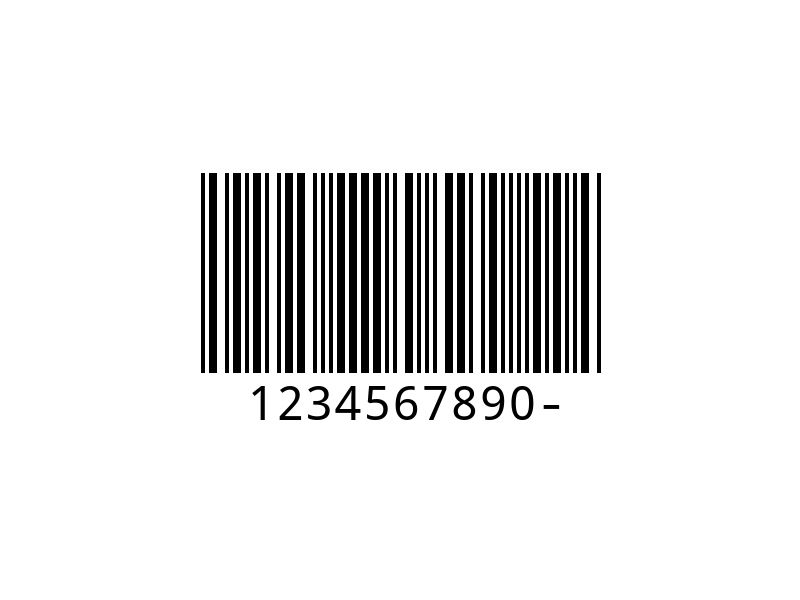

In [ ]:
img = cv2.imread("/content/01 - lol easy.jpg",cv2.IMREAD_GRAYSCALE)
print(img.shape)
cv2_imshow(img)

#Main

Magnitude Spectrum (Normalized):
[[0.084 0.073 0.07  ... 0.077 0.07  0.073]
 [0.085 0.12  0.1   ... 0.03  0.105 0.127]
 [0.089 0.071 0.128 ... 0.074 0.038 0.127]
 ...
 [0.092 0.086 0.059 ... 0.092 0.075 0.06 ]
 [0.089 0.127 0.038 ... 0.106 0.128 0.071]
 [0.085 0.127 0.105 ... 0.034 0.1   0.12 ]]
Highest Value in Magnitude Spectrum: 255.0
Position of Highest Value: (300, 325)
3.126045840418528
Z-score of the Maximum Value: 81.35135314082957
False
False
False
False
False
False
90.0
False
False


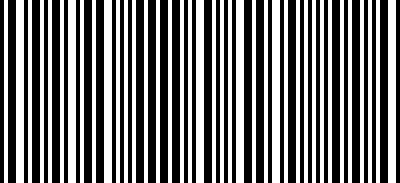

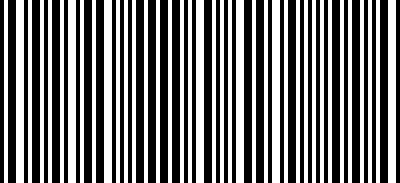

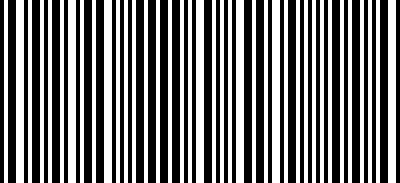

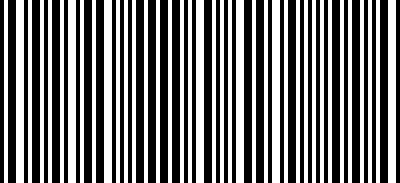

'\nbest organization except for last\ncontoured= contour(imgafterpreproc)\ncropped=crop_rows(contoured,2)\ncv2_imshow(cropped)\nimgafterpreproc = apply_closing(cropped)\ncv2_imshow(imgafterpreproc)\nheight=calculate_vertical_bar_height(imgafterpreproc)\nimgafterpreproc= apply_opening(imgafterpreproc,height)\ncv2_imshow(imgafterpreproc)\n'

In [ ]:

Blur_flag = detect_blurred(img)
contrast_flag= detect_contrast(img)
salt_pepper_flag= detect_sltnp(img)
high_Brightness_flag= detect_high_brightness(img)
low_Brightness_flag= detect_low_brightness(img)
periodic_flag= detect_periodic(img)


print(Blur_flag)
print(contrast_flag)
print(salt_pepper_flag)
print(high_Brightness_flag)
print(low_Brightness_flag)
print(periodic_flag)

imgafterpreproc= img.copy()

if(periodic_flag==True):
    imgafterpreproc= periodic_noise_removal(imgafterpreproc,0.1)
if(Blur_flag==True):
    imgafterpreproc= Sharpen(img)
if(high_Brightness_flag==True):
    imgafterpreproc=gamma_correction(imgafterpreproc,30)

if(low_Brightness_flag==True):
    imgafterpreproc=process_dark_barcode(imgafterpreproc)

if(salt_pepper_flag ==True):
    imgafterpreproc=sheel_mal7_wfelfel(imgafterpreproc)

if(contrast_flag==True):
    imgafterpreproc=la2ena_el_contrast(imgafterpreproc)



is_rotated_flag= is_rotated(imgafterpreproc,90)
print(is_rotated_flag)
if(is_rotated_flag==True):
   imgafterpreproc=contour_rotated(imgafterpreproc)


Obstacle_flag= obstacle_detection(imgafterpreproc)
print(Obstacle_flag)
if(Obstacle_flag==True):
    imgafterpreproc= remove_Obstacle(imgafterpreproc)


threshed= thresholding(imgafterpreproc)
contoured= contour(threshed)
cropped=crop_rows(contoured,3)
cv2_imshow(cropped)
imgafterpreproc = cv2.morphologyEx(cropped, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 2)))
cv2_imshow(imgafterpreproc)
height=calculate_vertical_bar_height(imgafterpreproc)
imgafterpreproc= apply_opening(imgafterpreproc,height)
cv2_imshow(imgafterpreproc)
imgafterpreproc = apply_closing(imgafterpreproc)
threshed= thresholding(imgafterpreproc)
imgafterpreproc= contour(threshed)
cv2_imshow(imgafterpreproc)










"""
best for last
contoured= contour(rotated)
final= apply_opening(contoured,200)
closed= apply_closing(final,200)
cv2_imshow(closed)
"""


"""
best organization except for last
contoured= contour(imgafterpreproc)
cropped=crop_rows(contoured,2)
cv2_imshow(cropped)
imgafterpreproc = apply_closing(cropped)
cv2_imshow(imgafterpreproc)
height=calculate_vertical_bar_height(imgafterpreproc)
imgafterpreproc= apply_opening(imgafterpreproc,height)
cv2_imshow(imgafterpreproc)
"""







#Decoder

In [ ]:

# Define tolerance value
TOLERANCE = 1

# Define bar width patterns
NARROW = "0"
WIDE = "1"

code11_widths = {
    "00110": "Stop/Start",
    "10001": "1",
    "01001": "2",
    "11000": "3",
    "00101": "4",
    "10100": "5",
    "01100": "6",
    "00011": "7",
    "10010": "8",
    "10000": "9",
    "00001": "0",
    "00100": "-",
}

def within_tolerance(width, target_size):
    return abs(width - target_size) <= TOLERANCE

def decode_barcode(img):
    # Get the average of each column in the image
    mean = img.mean(axis=0)

    # Set pixels to black (1) or white (0) based on threshold
    mean[mean <= 127] = 1  # Black
    mean[mean > 127] = 0   # White

    # Convert to string of pixels
    pixels = ''.join(mean.astype(np.uint8).astype(str))

    # Measure bar widths
    bar_widths = []
    count = 1
    color = pixels[0]  # Initialize the first color

    for i in range(1, len(pixels)):
        if pixels[i] == pixels[i - 1]:
            count += 1
        else:
            # Append the current bar with its color and width
            bar_widths.append([int(color), count])
            color = pixels[i]  # Update the color to the current pixel
            count = 1

    # Append the last bar
    bar_widths.append([int(color), count])

    # Determine narrow and wide bar sizes
    black_narrow_bar_size = min(bar[1] for bar in bar_widths if bar[0] == 1)
    black_wide_bar_size = max(bar[1] for bar in bar_widths if bar[0] == 1)
    white_narrow_bar_size = min(bar[1] for bar in bar_widths if bar[0] == 0)
    white_wide_bar_size = max(bar[1] for bar in bar_widths if bar[0] == 0)

    # Decode the barcode
    digits = []
    pixel_index = 0
    current_digit_widths = ""
    skip_next = False

    while pixel_index < len(pixels):
        if skip_next:
            if pixels[pixel_index] == '1':
                pixel_index += black_narrow_bar_size
            else:
                pixel_index += white_narrow_bar_size
            skip_next = False
            continue

        count = 1
        try:
            while pixels[pixel_index] == pixels[pixel_index + 1]:
                count += 1
                pixel_index += 1
        except IndexError:
            pass

        pixel_index += 1
        current_color = 1 if pixels[pixel_index - 1] == '1' else 0

        if current_color == 1:  # Black bar
            if within_tolerance(count, black_narrow_bar_size):
                current_digit_widths += NARROW
            elif within_tolerance(count, black_wide_bar_size):
                current_digit_widths += WIDE
            else:
                print(f"Unclassified black bar width: {count}")
        else:  # White bar
            if within_tolerance(count, white_narrow_bar_size):
                current_digit_widths += NARROW
            elif within_tolerance(count, white_wide_bar_size):
                current_digit_widths += WIDE
            else:
                print(f"Unclassified white bar width: {count}")

        if current_digit_widths in code11_widths:
            digits.append(code11_widths[current_digit_widths])
            current_digit_widths = ""
            skip_next = True  # Next iteration will be a separator, so skip it

    return digits


decoded_digits = decode_barcode(imgafterpreproc)
print("Decoded digits:", decoded_digits)


Decoded digits: ['Stop/Start', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '-', 'Stop/Start']
